In [658]:
# Imports
import sys
sys.path.append('../../../utils')

from default_imports import *
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from tqdm import tqdm

In [659]:
# Load data
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

# MLP Regressor
03_MLP_regressor.ipynb

In [660]:
def get_device():
    if torch.backends.mps.is_available():  # Apple Silicon GPUs
        return torch.device("mps")
    elif torch.cuda.is_available():       # NVIDIA GPUs
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [661]:
BATCH_SIZE = 512
NUM_CATEGORIES = train_df['grade_subgrade'].nunique()
device = get_device()
device = 'cpu'
print(f"Using: {device}")

Using: cpu


In [662]:
train_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,grade_subgrade,loan_paid_back,gender_Female,gender_Male,...,employment_status_Student,employment_status_Unemployed,loan_purpose_Business,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
0,0,29367.99,0.084,736,2528.42,13.67,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,22108.02,0.166,636,4593.10,12.92,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,49566.20,0.097,694,17005.15,9.76,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,46858.25,0.065,533,4682.48,16.10,3.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,25496.70,0.053,665,12184.43,10.21,4.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Dataset

In [663]:
class LoanDataset(Dataset):
    def __init__(self, data, target_col: str, id_col: str, categorical_col: str):
        self.ids = torch.tensor(data[id_col].values, dtype=torch.long)
        self.categorical = torch.tensor(data[categorical_col].values, dtype=torch.long)
        
        cont_cols = data.columns.difference([id_col, target_col, categorical_col])
        self.continuous = torch.tensor(data[cont_cols].values, dtype=torch.float32)
        
        if target_col is not None:
            self.target = torch.tensor(data[target_col].values, dtype=torch.float32)
        else:
            self.target = None

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        x_id = self.ids[idx]
        x_cont = self.continuous[idx]
        x_cat = self.categorical[idx]

        if self.target is None:
            return x_id, x_cont, x_cat
        else:
            y = self.target[idx]
            return x_id, x_cont, x_cat, y

In [664]:
dataset = LoanDataset(train_df, 'loan_paid_back', 'id', 'grade_subgrade')
dataset[15]

(tensor(15),
 tensor([5.3938e+04, 7.0300e+02, 5.1000e-02, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0980e+01, 4.1924e+03,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]),
 tensor(6),
 tensor(1.))

In [665]:
test_dataset = LoanDataset(test_df, None, 'id', 'grade_subgrade')
test_dataset[0]

(tensor(593994),
 tensor([2.8781e+04, 6.2600e+02, 4.9000e-02, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.4730e+01, 1.1461e+04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]),
 tensor(5))

## Train/Val split

In [666]:
#dataset = Subset(dataset, indices=range(10000))

In [667]:
dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

Train dataset size: 534594
Val dataset size: 59400


## Normalization

In [668]:
train_cont = torch.stack([x[1] for x in train_dataset])  # assuming x[1] is continuous features
train_mean = train_cont.mean(dim=0)
train_std = train_cont.std(dim=0)

In [669]:
def normalize_continuous(x, mean, std):
    x_cont = x[1]
    x_cont = (x_cont - mean) / std
    # return a tuple with normalized continuous features
    return (x[0], x_cont, x[2]) if len(x) == 3 else (x[0], x_cont, x[2], x[3])

train_dataset_normalized = [(normalize_continuous(x, train_mean, train_std)) for x in train_dataset]
val_dataset_normalized = [(normalize_continuous(x, train_mean, train_std)) for x in val_dataset]
test_dataset_normalized = [(normalize_continuous(x, train_mean, train_std)) for x in test_dataset]

## Model

In [670]:
train_loader = DataLoader(train_dataset_normalized, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_normalized, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset_normalized, batch_size=BATCH_SIZE, shuffle=False)

In [680]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout=0.1):
        super().__init__()
        self.fc = nn.Linear(size, size)
        self.bn = nn.BatchNorm1d(size)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        return out + x  # residual connection

class MLPRegressor(nn.Module):
    def __init__(self, 
                 num_categories, 
                 embedding_dim,
                 input_size, 
                 hidden_sizes, 
                 output_size,
                 dropout=0.1):
        """
        num_categories: number of unique values in the categorical column
        embedding_dim: size of the embedding vector
        input_size: number of other input features
        hidden_sizes: list of hidden layer sizes
        output_size: number of outputs
        """
        super().__init__()

        self.embedding = nn.Embedding(num_categories, embedding_dim)
        
        self.hidden_layers = nn.ModuleList()
        in_size = embedding_dim + input_size

        for h in hidden_sizes:
            if in_size == h:
                # Use residual block if input/output sizes match
                self.hidden_layers.append(ResidualBlock(h, dropout))
            else:
                # Standard linear → batch norm → activation
                self.hidden_layers.append(nn.Sequential(
                    nn.Linear(in_size, h),
                    nn.BatchNorm1d(h),
                    nn.GELU(),
                    nn.Dropout(dropout)
                ))
            in_size = h
        
        self.output_layer = nn.Linear(in_size, output_size)  # output layer
        
    def forward(self, x_cont, x_cat):
        emb = self.embedding(x_cat)
        x = torch.cat([x_cont, emb], dim=1)
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        return self.output_layer(x)

In [681]:
test_model = MLPRegressor(
    num_categories=NUM_CATEGORIES,
    embedding_dim=16,
    input_size=len(dataset[0][1]),
    hidden_sizes=[32, 16],
    output_size=1,
    dropout=0.1
)

for batch in train_loader:
    x_cont = batch[1]
    x_cat = batch[2]
    print(test_model(x_cont, x_cat).shape)
    break

torch.Size([512, 1])


## Training

In [682]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=10, patience=3):
    """
    model: PyTorch nn.Module
    train_loader, val_loader: DataLoader objects
    loss_fn: loss function (e.g., nn.MSELoss, nn.BCEWithLogitsLoss)
    optimizer: optimizer (e.g., torch.optim.Adam)
    device: torch.device('cpu'/'cuda'/'mps')
    epochs: maximum number of epochs
    """
    model.to(device)
    train_losses = []
    val_losses = []

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # ----- Training -----
        model.train()
        running_train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for _, x_cont, x_cat, target in train_iter:
            x_cont, x_cat, target = x_cont.to(device), x_cat.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(x_cont, x_cat)
            loss = loss_fn(outputs, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_cont.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # ----- Validation -----
        model.eval()
        running_val_loss = 0.0
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for _, x_cont, x_cat, target in val_iter:
                x_cont, x_cat, target = x_cont.to(device), x_cat.to(device), target.to(device)
                outputs = model(x_cont, x_cat)
                loss = loss_fn(outputs, target.unsqueeze(1))
                running_val_loss += loss.item() * x_cont.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # ----- Early stopping check -----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    return train_losses, val_losses

In [684]:
model = MLPRegressor(
    num_categories=NUM_CATEGORIES,
    embedding_dim=16,
    input_size=len(dataset[0][1]),
    hidden_sizes=[64, 64, 32, 32, 32, 64, 64],
    output_size=1,
    dropout=0.2
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)

train_losses, val_losses = train_model(model, train_loader, val_loader, nn.BCEWithLogitsLoss(), optimizer, device, epochs=20, patience=5)

Epoch 1/20: Train Loss = 0.2669, Val Loss = 0.2595


Epoch 2/20: Train Loss = 0.2612, Val Loss = 0.2578


Epoch 3/20: Train Loss = 0.2605, Val Loss = 0.2580


Epoch 4/20: Train Loss = 0.2602, Val Loss = 0.2585


Epoch 5/20: Train Loss = 0.2597, Val Loss = 0.2580


Epoch 6/20: Train Loss = 0.2595, Val Loss = 0.2582


Epoch 7/20: Train Loss = 0.2592, Val Loss = 0.2584


Early stopping triggered at epoch 8


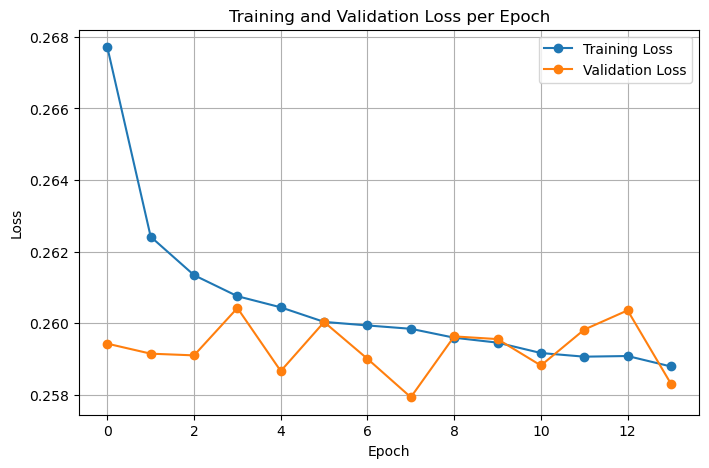

In [675]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Output

In [676]:
def generate_predictions_file(model, data_loader, device, output_file="../output/MLP_regression.csv"):
    model.eval()
    model.to(device)

    all_ids = []
    all_probs = []

    with torch.no_grad():
        for x_id, x_cont, x_cat in data_loader:  # assuming your Dataset returns id as third element
            x_cont, x_cat = x_cont.to(device), x_cat.to(device)
            
            # Forward pass
            logits = model(x_cont, x_cat)
            probs = torch.sigmoid(logits).squeeze(1)  # convert logits to probabilities

            all_ids.extend(x_id.tolist())
            all_probs.extend(probs.cpu().tolist())

    # Create DataFrame and save
    df_out = pd.DataFrame({
        "id": all_ids,
        "probability": all_probs
    })
    df_out.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

In [677]:
generate_predictions_file(model, test_loader, device=device)

Predictions saved to ../output/MLP_regression.csv
